# The main implementation of thesis project

# Introduction

In this Python notesbook, we choose the following as baselines and evaluate their performances:
- Supervised learning with simple network
- Supervised learning with ResNet50
- Supervised learning with VGG16
- Supervised learning with MobileNet

We then evaluate our self-supervised contrastive model, which uses InfoNCE, known as NT-Xent (Normalized Temperature-scaled Cross Entropy Loss) in SimCLR and used in other works like MoCo. 

The goal of our texture classification model is to train an embedding space constrained by contrastive loss, our model consists of two image augmentation transformers, base encoder, a projection head, and a pure linear regressor with cross-entropy loss as the customised accuracy metric.

# Importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras

# enable GPU
#import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#os.environ["RUNFILES_DIR"] = "/usr/local/anaconda3/share/plaidml"
#os.environ["PLAIDML_NATIVE_PATH"] = "/usr/local/anaconda3/lib/libplaidml.dylib"
#import keras

# Setting local library path

Our modules lie in the directory *lib*, we add the path to the library searching path:

In [2]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

# Configurations

In [3]:
#image_size = (128, 128)
image_size = (64, 64) #faster for running on laptop



n_image_channels = 3

#input image shape
image_shape = (*image_size, n_image_channels) 


# sample batch size
batch_size = 128  
#batch_size = 64


# how many epochs
n_epochs = 20

temperature = 0.2
#temperature = 0.5




imgaug_params = { "image_shape": image_shape,
                  "min_area": 0.75, 
                  "brightness": 0.3, 
                  "jitter": 0.1}


# self-supervised contrastive learning
#strong_imgaug_params = {"image_shape": image_shape,
#                             "min_area": 0.25, 
#                             "brightness": 0.6, 
#                             "jitter": 0.2}

# for linear regression based metric
#weak_imgaug_params = { "image_shape": image_shape,
#                            "min_area": 0.75, 
#                            "brightness": 0.3, 
#                            "jitter": 0.1}

# Preparing the dataset

## Loading datasets

In [4]:
train_dataset_ = tf.keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/train", 
                image_size = image_size, 
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                shuffle = True,
                seed = 2113
                )

Found 30800 files belonging to 154 classes.


In [5]:
test_dataset_ = tf.keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/test", 
                image_size = image_size, 
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                shuffle = True,
                seed = 3371
                )

Found 7700 files belonging to 154 classes.


In [6]:
n_classes = len(train_dataset_.class_names)
print("n_classes = ", n_classes)

n_classes =  154


In [7]:
n_train_samples = len(train_dataset_) * batch_size
n_train_batches = len(train_dataset_)

print("n_train_samples = ", n_train_samples)
print("n_train_batches = ", n_train_batches)

n_train_samples =  30848
n_train_batches =  241


In [8]:
n_test_samples = len(test_dataset_) * batch_size
n_test_batches = len(test_dataset_)

print("n_test_samples = ", n_test_samples)
print("n_test_batches = ", n_test_batches)

n_test_samples =  7808
n_test_batches =  61


In [9]:
n_samples = n_train_samples + n_test_samples
n_batches = n_train_batches + n_test_batches

print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_samples =  38656
n_batches =  302


## Normalising datasets and setting data prefetching

In [10]:
train_dataset = train_dataset_.map(lambda x, y: (x / 255., y))
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

test_dataset = test_dataset_.map(lambda x, y: (x / 255., y))
test_dataset = test_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

## Verifying loaded dataset

In [11]:
x1 = next(iter(train_dataset))
x2 = x1[0]
x2.shape

TensorShape([128, 64, 64, 3])

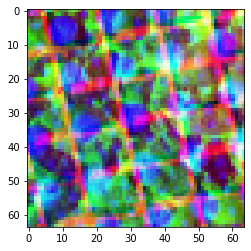

In [12]:
import matplotlib.pyplot as plt

img = next(iter(train_dataset))[0][0]

plt.imshow(img, vmin=0, vmax=1)
plt.show()

# Image augmentation model

## Random color affine transformation layer

Random color affine transformation is crucial to avoid trivial solution of merely learning classification from color histogram information!

In [ ]:
 # We make it working with keras model save and load
# ref: 
# https://keras.io/guides/serialization_and_saving/
# https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
# https://keras.io/examples/vision/semisupervised_simclr/

import numpy as np
import tensorflow as tf
from tensorflow import keras


class CustomisedRandomColorAffineLayer(keras.layers.Layer):

    def __init__(self, 
                 brightness = 0, 
                 jitter = 0, 
                 name = 'color_affine',
                 **kwargs):

        self.brightness = brightness
        self.jitter = jitter
        #self.brightness = tf.Variable(brightness, name="brightness")
        #self.jitter = tf.Variable(jitter, name="jitter")

        super(CustomisedRandomColorAffineLayer, self).__init__(**kwargs)
        

    def get_config(self):
        
        #config = super(CustomisedRandomColorAffineLayer, self).get_config()
        config = super().get_config()


        #config['brightness'] = self.brightness.numpy()
        #config['jitter'] = self.jitter.numpy()

        config['brightness'] = self.brightness
        config['jitter'] = self.jitter

        #print("config = ", config)

        return config

    #@classmethod
    #def from_config(cls, config):
    #    return cls(**config)

    def call(self, images, training = True):
        if training:
            batch_size = tf.shape(images)[0]

            # For each pixels, we randomly adjust their brightnesses.
            brightness_scales = 1 + tf.random.uniform(
                            (batch_size, 1, 1, 1), 
                            minval = -self.brightness, 
                            maxval = self.brightness
                        )

            # Different for all colors
            jitter_matrices = tf.random.uniform(
                            (batch_size, 1, 3, 3), 
                            minval = -self.jitter, 
                            maxval = self.jitter
                        )

            color_transforms = (
                            tf.eye(3, batch_shape = [batch_size, 1]) * brightness_scales
                                + jitter_matrices
                        )

            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)

        return images

## Image augmentation model for train

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


class CustomisedTrainImageAugmenter(keras.layers.Layer):
    def __init__(self, 
                 image_shape,
                 min_area,
                 brightness,
                 jitter,
                 name = 'train_imgaug_layer',
                 **kwargs):

        self.image_shape = image_shape
        self.min_area = min_area
        self.brightness = brightness
        self.jitter = jitter


        #self.zoom_factor = 1.0 - tf.sqrt(min_area)
        self.zoom_factor = 1.0 - np.sqrt(min_area)

        self.model = keras.Sequential(
           [
            keras.layers.InputLayer(input_shape = image_shape),
            #preprocessing.Rescaling(1 / 255),
            keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
            keras.layers.experimental.preprocessing.RandomTranslation(
                                            self.zoom_factor / 2, 
                                            self.zoom_factor / 2
                                           ),
            keras.layers.experimental.preprocessing.RandomZoom(
                                            (-self.zoom_factor, 0.0), 
                                            (-self.zoom_factor, 0.0)
                                        ),
            CustomisedRandomColorAffineLayer(   brightness = brightness, 
                                                jitter = jitter, 
                                                name = "color_affine_for_train"),
            ],
            name = "train_imgaug_model"
          )

        super(CustomisedTrainImageAugmenter, self).__init__(name = name, **kwargs)

    def get_config(self):
        config = super().get_config()
        
        config['image_shape'] = self.image_shape
        config['min_area'] = self.min_area
        config['brightness'] = self.brightness
        config['jitter'] = self.jitter
        config['zoom_factor'] = self.zoom_factor
        config['model'] = self.model

        #print(config)

        return config

    def call(self, images, training = True):
        if training:
            outputs = self.model(images)
        else:
            outputs = images

        return outputs

    @classmethod
    def from_config(cls, config):
        return cls(**config)




## Image augmentation model for utility

In [ ]:

class CustomisedUtilImageAugmenter(keras.layers.Layer):
    def __init__(self,
                 image_shape = (256, 512, 3),
                 target_shape = (128, 128, 3),
                 seed = 21,
                 name = 'util_imgaug_layer',
                 **kwargs):

        self.image_shape = image_shape
        self.target_shape = target_shape
        self.seed = seed

        self.model = keras.Sequential([
              keras.layers.InputLayer(input_shape = self.image_shape), 
              #keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
              #keras.layers.experimental.preprocessing.Normalization(),
              #keras.layers.experimental.preprocessing.RandomFlip(seed = seed),
              #keras.layers.experimental.preprocessing.RandomZoom(0.5),
              keras.layers.experimental.preprocessing.RandomRotation(0.5, seed = self.seed),
              keras.layers.experimental.preprocessing.RandomCrop(self.target_shape[0],
                                                                 self.target_shape[1],
                                                                 seed = self.seed)

             ],
             name = "util_imgaug_model")

        super(CustomisedUtilImageAugmenter, self).__init__(name = name, **kwargs)

    def get_config(self):
        config = super().get_config()
        
        config['image_shape'] = self.image_shape
        config['target_shape'] = self.target_shape
        config['seed'] = self.seed
        config['model'] = self.model

        return config

    def call(self, images, training = False):
        outputs = self.model(images)
        return outputs

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Visualising

## Plotting samples

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


""" We plot the sample images from the dataset. 
"""

def plot_dataset_samples(*,
                         dataset, 
                         nrows = 4, 
                         ncols = 4, 
                         subfig_height = 4, 
                         subfig_width = 4):
    
    
    
    
    """ Plotting the samples 
    
    """

    figsize = (ncols * subfig_width, nrows * subfig_height) 
    #figsize = (15, 15) 

    

    """ Sampling
    
    """
    dfs = df.sample(n = nrows * ncols, replace = False)
    
    Xs = np.array(dfs["X"], dtype = object)
    ys = np.array(dfs["y"], dtype = object)
    
    
    fig, axes = plt.subplots(nrows = nrows,
                             ncols = ncols,
                             figsize = figsize)
    
    """ plt.subplots_adjust(left = 0.02,
                    right = 0.97,
                    bottom = 0.05,
                    hspace = 0.1,
                    wspace = 0.1,
                    top = 0.95)
    """

    axes_flat = axes.flat
    
    
    for row in range(nrows):
        for col in range(ncols):
            
            imgid = row * ncols + col
            
            img = Xs[imgid]
            img = np.array(img, dtype = np.uint8) #print("img.shape", img.shape)
            
            label = ys[imgid]
            
            ax = axes_flat[row * ncols + col] 
            ax.set_xticks([])
            ax.set_yticks([])
            #ax.imshow(img, vmin = 0, vmax = 1) 
            ax.imshow(img) 
            ax.title.set_text(f"{label} #{imgid}")

    plt.show()
    plt.close()

## Plotting augmented various samples

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def plot_augmented_samples(*, 
                           dataset, 
                           img_augmenter, 
                           nrows = 2, 
                           ncols = 4, 
                           subfig_width = 4, 
                           subfig_height = 4):

    X, y = next(iter(dataset))
    
    #X,y = load_mbt_dataset()

    #X_train, y_train, X_test, y_test = split_mbt_dataset(X, y)

    #img_augmenter = CustomisedUtilImageAugmenter()


    figsize = (ncols * subfig_width, nrows * subfig_height)

    fig, axes = plt.subplots(nrows = nrows,
                             ncols = ncols,
                             figsize = figsize)

    """ plt.subplots_adjust(left = 0.02,
                    right = 0.97,
                    bottom = 0.05,
                    hspace = 0.1,
                    wspace = 0.1,
                    top = 0.95)
    """

    axes_flat = axes.flat


    for row in range(nrows):
        for col in range(ncols):

            imgid = row * ncols + col

            Xi = X[imgid, :, :, :]
            #Xi = X_train[3, :, :, :]
            Xi = Xi.copy()
            Xi = np.expand_dims(Xi, axis = 0)
            Xi = img_augmenter(Xi)
            #Xi = np.array(Xi, dtype = np.uint8)
            img = Xi[0, :, :, :]

            #img = X_train[imgid, :, :, :]
            img = np.array(img, dtype = np.uint8) #print("img.shape", img.shape)

            label = y[imgid]

            ax = axes_flat[row * ncols + col]
            ax.set_xticks([])
            ax.set_yticks([])
            #ax.imshow(img, vmin = 0, vmax = 1.0)
            ax.imshow(img)
            ax.title.set_text(f"{label} #{imgid}")

    plt.show()
    plt.close()

## Plotting augmented samples for one image

In [ ]:
def plot_augmented_samples_for_one_image(*, 
                                         dataset, 
                                         img_augmenter, 
                                         nrows = 2, 
                                         ncols = 4, 
                                         subfig_width = 4, 
                                         subfig_height = 4):
    
    
    
    X, y = next(iter(dataset))
    
    #X,y = load_mbt_dataset()
    #X_train, y_train, X_test, y_test = split_mbt_dataset(X, y)
    
    #img_augmenter = CustomisedUtilImageAugmenter()
    
    
    figsize = (ncols * subfig_width, nrows * subfig_height) 
    
    fig, axes = plt.subplots(nrows = nrows,
                             ncols = ncols,
                             figsize = figsize)
    
    """ plt.subplots_adjust(left = 0.02,
                    right = 0.97,
                    bottom = 0.05,
                    hspace = 0.1,
                    wspace = 0.1,
                    top = 0.95)
    """

    axes_flat = axes.flat
    
    indices = list(range(len(y)))
    idx = np.random.choice(indices)
    candidate_image = X[idx, :, :, :]
    
    
    
    for row in range(nrows):
        for col in range(ncols):
            
            plotid = row * ncols + col
            
            Xi = candidate_image.copy()
            Xi = np.expand_dims(Xi, axis = 0)
            Xi = img_augmenter(Xi)
            #Xi = np.array(Xi * 255, dtype = np.uint8)
            img = Xi[0, :, :, :]
    
            #img = X_train[imgid, :, :, :]
            img = np.array(img, dtype = np.uint8) #print("img.shape", img.shape)
            
            label = y[idx]
            
            ax = axes_flat[row * ncols + col] 
            ax.set_xticks([])
            ax.set_yticks([])
            #ax.imshow(img, vmin = 0, vmax = 1.0) 
            ax.imshow(img) 
            ax.title.set_text(f"{label} #{plotid}")

    plt.show()
    plt.close()

## Plotting training dataset

## Plotting testing dataset

## Plotting augmented samples

## Plotting augmented samples for one image

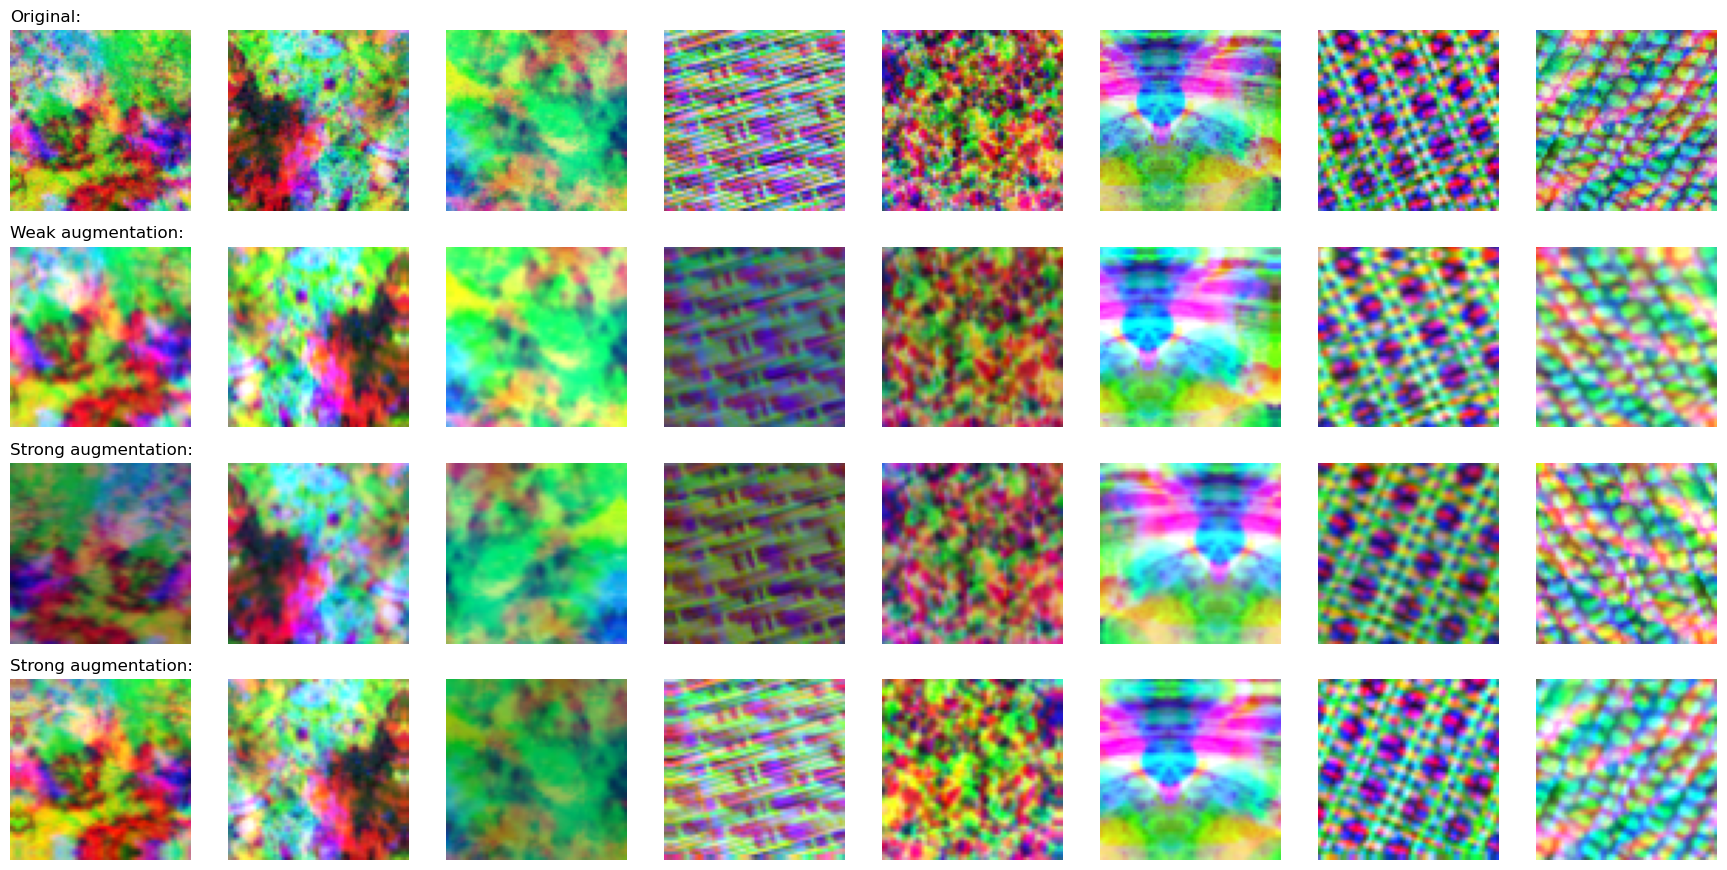

In [14]:
#plot_augmented_samples_train(dataset = train_dataset, 
#                             n_samples = 8, 
#                             strong_imgaug_params = imgaug_params, #strong_imgaug_params, 
#                             weak_imgaug_params = imgaug_params,  #weak_imgaug_params, 
#                             )

# Simple base encoder

In [15]:
def build_simple_encoder(image_shape):
    return keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=image_shape, dtype = "float32"),
            
            keras.layers.Conv2D(32, kernel_size=3, strides=2, activation="relu"),
            keras.layers.Conv2D(64, kernel_size=3, strides=2, activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            
            keras.layers.Conv2D(128, kernel_size=3, strides=2, activation="relu"),            
            keras.layers.Conv2D(256, kernel_size=3, strides=2, activation="relu"), 
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            
            keras.layers.Flatten(),
            
            #keras.layers.Dense(512, activation="relu", name = "encoder_output"),
            #keras.layers.Dense(512, activation="relu", name = "encoder_output"),
        ],
        
        name = "encoder_simple",
    )

# Building supervised learning model with specified encoder

In [16]:
def build_supervised_model( *,
                            learning_rate = 0.001,
                            image_shape,      
                            n_classes,
                            encoder, 
                            imgaug_params,
                            name
                           ):
    
    newhead = keras.Sequential(
                [
                    keras.layers.Dense(512, activation="relu", name = "hidden_1"),
                    keras.layers.Dense(512, activation="relu", name = "hidden_2"),
                    keras.layers.Dense(n_classes, name = "output"), 
                ], 
                name = "newhead"
            )
            
    
    model = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape = image_shape),
                CustomisedTrainImageAugmenter(**imgaug_params),
                encoder,
                newhead
            ],
            name = name,
        )

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
            loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            metrics = [keras.metrics.SparseCategoricalAccuracy(name = "acc")],
        )
    
    print()
    newhead.summary()
    
    print()
    encoder.summary()
    
    print()
    model.summary()
    
    return model

# Baseline: Supervised learning with simple encoder

## Building model

In [17]:
baseline_encoder_simple = build_simple_encoder(image_shape)
baseline_model_simple = build_supervised_model(image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_simple, 
                           imgaug_params = imgaug_params,
                           name = "baseline_model_simple",
                           learning_rate = 0.001)


Model: "newhead"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 512)               1180160   
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 154)               79002     
Total params: 1,521,818
Trainable params: 1,521,818
Non-trainable params: 0
_________________________________________________________________

Model: "encoder_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_______________________

## Training from scratch

In [18]:
baseline_simple_history = baseline_model_simple.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20
241/241 [==============================] - 41s 165ms/step - loss: 3.8548 - acc: 0.1070 - val_loss: 22.7876 - val_acc: 0.0070
Epoch 2/20
241/241 [==============================] - 49s 204ms/step - loss: 1.6894 - acc: 0.4783 - val_loss: 13.0002 - val_acc: 0.0210
Epoch 3/20
241/241 [==============================] - 51s 211ms/step - loss: 0.9062 - acc: 0.7042 - val_loss: 8.4719 - val_acc: 0.0883
Epoch 4/20
241/241 [==============================] - 50s 207ms/step - loss: 0.6313 - acc: 0.7871 - val_loss: 3.3801 - val_acc: 0.3453
Epoch 5/20
241/241 [==============================] - 48s 198ms/step - loss: 0.4851 - acc: 0.8317 - val_loss: 2.3403 - val_acc: 0.5005
Epoch 6/20
241/241 [==============================] - 46s 188ms/step - loss: 0.4242 - acc: 0.8556 - val_loss: 3.2194 - val_acc: 0.3923
Epoch 7/20
241/241 [==============================] - 47s 195ms/step - loss: 0.3750 - acc: 0.8728 - val_loss: 2.1622 - val_acc: 0.5339
Epoch 8/20
241/241 [==============================] -

## Saving models and results

In [19]:
baseline_encoder_simple.save("models/baseline_encoder_simple.saved_model")
baseline_model_simple.save("models/baseline_model_simple.saved_model")

INFO:tensorflow:Assets written to: models/baseline_encoder_simple.saved_model/assets
INFO:tensorflow:Assets written to: models/baseline_model_simple.saved_model/assets


In [20]:
import pickle
import os

if not os.path.exists("results"):
        os.makedirs("results")
        
pickle.dump(baseline_simple_history.history, 
            open("results/baseline_simple_history.pickle", "wb" ))

In [21]:
test_encoder = keras.models.load_model("models/baseline_encoder_simple.saved_model")
test_model = keras.models.load_model("models/baseline_model_simple.saved_model")

del test_encoder
del test_model

In [22]:
history = pickle.load(open(b"results/baseline_simple_history.pickle", "rb"))

max_val_acc = max(history["val_acc"]) * 100
max_train_acc = max(history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

Maximal train accuracy: 94.65%
Maximal validation accuracy: 63.73%


## Plotting

In [28]:
import pickle
import matplotlib.pyplot as plt
#from matplotlib import cm
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap





def plot_supervised_train_accuracy(resultfile):
    
    if not os.path.exists(resultfile):
        return
    
    history = pickle.load(open(resultfile, "rb"))

    val_accs = history["val_acc"]
    train_accs = history["acc"]


    plt.title("The training validation accuracy w.r.t. epochs")

    # https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html
    #viridis = cm.get_cmap('viridis', 2)
    #newcolors = viridis(np.linspace(0, 1, 2))
    #pink = np.array([248/256, 24/256, 148/256, 1]
    #newcolors[:25, :] = pink
    #newcmp = ListedColormap(newcolors)

    plt.plot(val_accs, color = "blue", label = "validation")
    plt.plot(train_accs, color = "coral", label = "training")

    plt.xlabel("# of epochs", fontsize = 12)
    plt.ylabel("Accuracy", fontsize = 12)

    plt.xlim(0, len(val_accs) - 1)
    plt.ylim(0, 1)

    xticks = np.linspace(0, 
                     len(val_accs) - 1, 
                     num = len(val_accs), 
                     endpoint = True, 
                     dtype = int)
    xlabels = xticks

    plt.xticks(xticks, xlabels)

    plt.legend( #loc = 'upper center',
            fontsize = 12,
            ncol = 1, frameon = False)

    plt.show()

In [29]:
def plot_supervised_train_loss(resultfile):
    
    if not os.path.exists(resultfile):
        return
    
    history = pickle.load(open(resultfile, "rb"))

    val_loss = history["val_loss"]
    train_loss = history["loss"]

    val_loss = np.array(val_loss) / max(val_loss)
    train_loss = np.array(train_loss) / max(train_loss)

    plt.title("The training validation losses w.r.t. epochs")

    plt.plot(val_loss, color = "blue", label = "validation")
    plt.plot(train_loss, color = "coral", label = "training")

    plt.xlabel("# of epochs", fontsize = 12)
    plt.ylabel("Loss", fontsize = 12)

    plt.xlim(0, len(val_loss) - 1)
    plt.ylim(0, 1)

    xticks = np.linspace(0, 
                     len(val_loss) - 1, 
                     num = len(val_loss), 
                     endpoint = True, 
                     dtype = int)
    xlabels = xticks

    plt.xticks(xticks, xlabels)

    plt.legend( #loc = 'upper center',
            fontsize = 12,
            ncol = 1, frameon = False)

    plt.show()

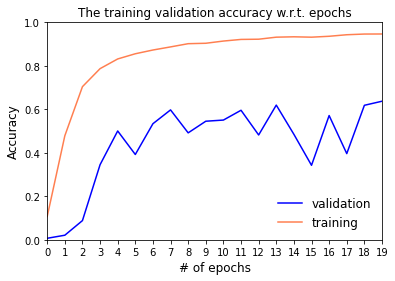

In [30]:
plot_supervised_train_accuracy(b"results/baseline_simple_history.pickle")

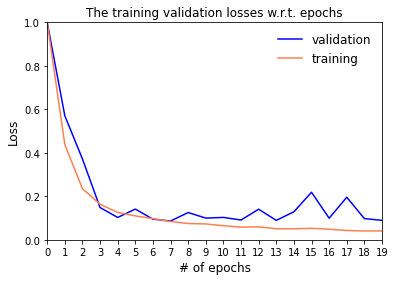

In [31]:
plot_supervised_train_loss(b"results/baseline_simple_history.pickle")

# Baseline: Supervised learning with VGG16

## Building VGG16 encoder

In [32]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

def build_vgg16_encoder(image_shape):
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
     
    #x = keras.layers.Lambda(vgg16_preprocess_input)(inputs)
    
    model_orig = VGG16(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   

    outputs = model_orig.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "vgg16_encoder")
    
    return model_new

## Building model

In [33]:
baseline_encoder_vgg16 = build_vgg16_encoder(image_shape)
baseline_encoder_vgg16.trainable = False

baseline_model_vgg16 = build_supervised_model(
                           image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_vgg16, 
                           imgaug_params = imgaug_params,
                           name = "baseline_model_vgg16",
                           learning_rate = 0.001
                        )


Model: "newhead"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 512)               262656    
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 154)               79002     
Total params: 604,314
Trainable params: 604,314
Non-trainable params: 0
_________________________________________________________________

Model: "vgg16_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
____________________________

## Training

In [34]:
baseline_vgg16_history = baseline_model_vgg16.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20
241/241 [==============================] - 483s 2s/step - loss: 2.2259 - acc: 0.3999 - val_loss: 1.8310 - val_acc: 0.4394
Epoch 2/20
241/241 [==============================] - 465s 2s/step - loss: 1.0764 - acc: 0.6567 - val_loss: 1.6650 - val_acc: 0.4962
Epoch 3/20
241/241 [==============================] - 458s 2s/step - loss: 0.8653 - acc: 0.7164 - val_loss: 1.5996 - val_acc: 0.5275
Epoch 4/20
241/241 [==============================] - 460s 2s/step - loss: 0.7487 - acc: 0.7491 - val_loss: 1.6835 - val_acc: 0.5322
Epoch 5/20
241/241 [==============================] - 465s 2s/step - loss: 0.7042 - acc: 0.7627 - val_loss: 1.5386 - val_acc: 0.5614
Epoch 6/20
241/241 [==============================] - 451s 2s/step - loss: 0.6494 - acc: 0.7793 - val_loss: 1.4818 - val_acc: 0.5786
Epoch 7/20
241/241 [==============================] - 452s 2s/step - loss: 0.6132 - acc: 0.7935 - val_loss: 1.5896 - val_acc: 0.5655
Epoch 8/20
241/241 [==============================] - 455s 2s/step - 

## Saving models and results

In [35]:
baseline_encoder_vgg16.save("models/baseline_encoder_vgg16.saved_model")
baseline_model_vgg16.save("models/baseline_model_vgg16.saved_model")

INFO:tensorflow:Assets written to: models/baseline_encoder_vgg16.saved_model/assets
INFO:tensorflow:Assets written to: models/baseline_model_vgg16.saved_model/assets


In [36]:
test_encoder = keras.models.load_model("models/baseline_encoder_vgg16.saved_model")
test_model = keras.models.load_model("models/baseline_model_vgg16.saved_model")

del test_encoder
del test_model

In [37]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(baseline_vgg16_history.history, 
            open("results/baseline_vgg16_history.pickle", "wb" ))

In [38]:
history = pickle.load(open(b"results/baseline_vgg16_history.pickle", "rb"))

max_val_acc = max(history["val_acc"]) * 100
max_train_acc = max(history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

Maximal train accuracy: 85.30%
Maximal validation accuracy: 61.34%


## Plotting

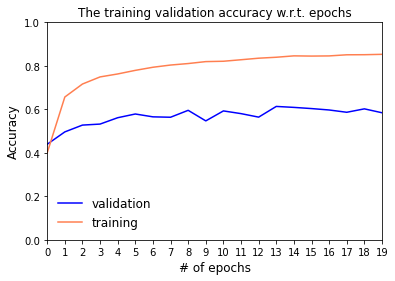

In [39]:
plot_supervised_train_accuracy(b"results/baseline_vgg16_history.pickle")

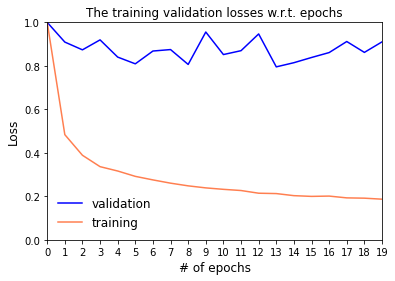

In [40]:
plot_supervised_train_loss(b"results/baseline_vgg16_history.pickle")

# Baseline: Supervised learning with ResNet50

## Building ResNet50 encoder

In [41]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

def build_resnet50_encoder(image_shape):
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
    #x = tf.keras.layers.Lambda(resnet50_preprocess_input)(inputs)
    
    model_orig = ResNet50(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   
    
    outputs = model_orig.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    
      
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "resnet50_encoder")
    
    return model_new

## Building model

In [42]:
baseline_encoder_resnet50 = build_resnet50_encoder(image_shape)
baseline_encoder_resnet50.trainable = False

baseline_model_resnet50 = build_supervised_model(
                           image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_resnet50, 
                           imgaug_params = imgaug_params,
                           name = "baseline_model_resnet50",
                           learning_rate = 0.001
                        )


Model: "newhead"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 512)               1049088   
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 154)               79002     
Total params: 1,390,746
Trainable params: 1,390,746
Non-trainable params: 0
_________________________________________________________________

Model: "resnet50_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 64, 64, 3)]  0                                            
______________________________________________________

## Training

In [43]:
baseline_resnet50_history = baseline_model_resnet50.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20
241/241 [==============================] - 212s 871ms/step - loss: 4.5699 - acc: 0.0295 - val_loss: 4.0583 - val_acc: 0.0474
Epoch 2/20
241/241 [==============================] - 210s 870ms/step - loss: 3.8402 - acc: 0.0738 - val_loss: 3.8799 - val_acc: 0.0732
Epoch 3/20
241/241 [==============================] - 209s 867ms/step - loss: 3.6458 - acc: 0.0993 - val_loss: 4.3140 - val_acc: 0.0626
Epoch 4/20
241/241 [==============================] - 210s 869ms/step - loss: 3.5376 - acc: 0.1107 - val_loss: 4.0615 - val_acc: 0.0853
Epoch 5/20
241/241 [==============================] - 209s 867ms/step - loss: 3.4541 - acc: 0.1270 - val_loss: 4.3467 - val_acc: 0.0699
Epoch 6/20
241/241 [==============================] - 210s 872ms/step - loss: 3.3867 - acc: 0.1377 - val_loss: 4.0243 - val_acc: 0.0909
Epoch 7/20
241/241 [==============================] - 210s 870ms/step - loss: 3.3253 - acc: 0.1467 - val_loss: 3.9060 - val_acc: 0.1053
Epoch 8/20
241/241 [============================

## Saving models and results

In [44]:
baseline_encoder_resnet50.save("models/baseline_encoder_resnet50.saved_model")
baseline_model_resnet50.save("models/baseline_model_resnet50.saved_model")

/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/baseline_encoder_resnet50.saved_model/assets


/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/baseline_model_resnet50.saved_model/assets


In [45]:
test_encoder = keras.models.load_model("models/baseline_encoder_resnet50.saved_model")
test_model = keras.models.load_model("models/baseline_model_resnet50.saved_model")

del test_encoder
del test_model

In [46]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(baseline_resnet50_history.history, 
            open("results/baseline_resnet50_history.pickle", "wb" ))

In [47]:
history = pickle.load(open(b"results/baseline_resnet50_history.pickle", "rb"))

max_val_acc = max(history["val_acc"]) * 100
max_train_acc = max(history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

Maximal train accuracy: 21.78%
Maximal validation accuracy: 13.45%


## Plotting

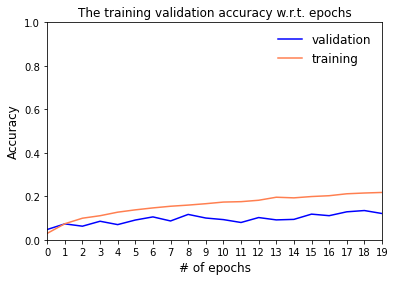

In [48]:
plot_supervised_train_accuracy(b"results/baseline_resnet50_history.pickle")

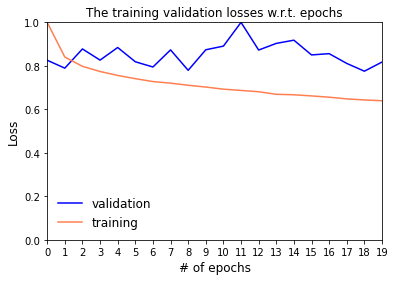

In [49]:
plot_supervised_train_loss(b"results/baseline_resnet50_history.pickle")

# Baseline: Supervised learning with MobileNet

## Building MobileNet encoder

In [50]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input

def build_mobilenet_encoder(image_shape):
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
    #x = tf.keras.layers.Lambda(resnet50_preprocess_input)(inputs)
    
    model_orig = MobileNet(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   
    
    outputs = model_orig.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    
      
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "mobilenet_encoder")
    
    return model_new

## Building model

In [51]:
baseline_encoder_mobilenet = build_mobilenet_encoder(image_shape)
baseline_encoder_mobilenet.trainable = False

baseline_model_mobilenet = build_supervised_model(
                           image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_mobilenet, 
                           imgaug_params = imgaug_params,
                           name = "baseline_model_mobilenet",
                           learning_rate = 0.001
                        )


Model: "newhead"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 512)               524800    
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 154)               79002     
Total params: 866,458
Trainable params: 866,458
Non-trainable params: 0
_________________________________________________________________

Model: "mobilenet_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
________________________

## Training

In [52]:
baseline_mobilenet_history = baseline_model_mobilenet.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20
241/241 [==============================] - 60s 244ms/step - loss: 2.4869 - acc: 0.3499 - val_loss: 2.2474 - val_acc: 0.3657
Epoch 2/20
241/241 [==============================] - 64s 266ms/step - loss: 1.7105 - acc: 0.4935 - val_loss: 2.0970 - val_acc: 0.4001
Epoch 3/20
241/241 [==============================] - 65s 270ms/step - loss: 1.5732 - acc: 0.5300 - val_loss: 2.0316 - val_acc: 0.4255
Epoch 4/20
241/241 [==============================] - 65s 267ms/step - loss: 1.4817 - acc: 0.5554 - val_loss: 2.1271 - val_acc: 0.4147
Epoch 5/20
241/241 [==============================] - 65s 268ms/step - loss: 1.4303 - acc: 0.5668 - val_loss: 2.0639 - val_acc: 0.4297
Epoch 6/20
241/241 [==============================] - 65s 270ms/step - loss: 1.3879 - acc: 0.5795 - val_loss: 2.0312 - val_acc: 0.4295
Epoch 7/20
241/241 [==============================] - 65s 269ms/step - loss: 1.3586 - acc: 0.5886 - val_loss: 2.0488 - val_acc: 0.4368
Epoch 8/20
241/241 [==============================] - 6

## Saving models and results

In [53]:
baseline_encoder_mobilenet.save("models/baseline_encoder_mobilenet.saved_model")
baseline_model_mobilenet.save("models/baseline_model_mobilenet.saved_model")

INFO:tensorflow:Assets written to: models/baseline_encoder_mobilenet.saved_model/assets
INFO:tensorflow:Assets written to: models/baseline_model_mobilenet.saved_model/assets


In [54]:
test_encoder = keras.models.load_model("models/baseline_encoder_mobilenet.saved_model")
test_model = keras.models.load_model("models/baseline_model_mobilenet.saved_model")

del test_encoder
del test_model

In [60]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(baseline_mobilenet_history.history, 
            open("results/baseline_mobilenet_history.pickle", "wb" ))

In [61]:
history = pickle.load(open(b"results/baseline_mobilenet_history.pickle", "rb"))

max_val_acc = max(history["val_acc"]) * 100
max_train_acc = max(history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

Maximal train accuracy: 63.60%
Maximal validation accuracy: 45.84%


## Plotting

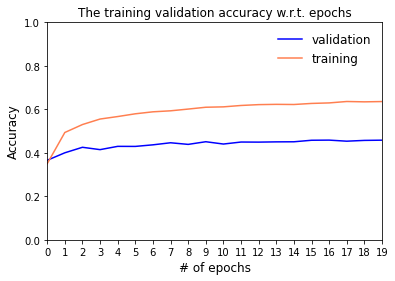

In [62]:
plot_supervised_train_accuracy(b"results/baseline_mobilenet_history.pickle")

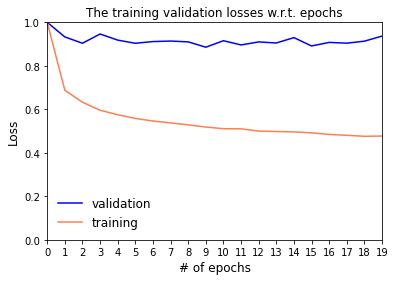

In [63]:
plot_supervised_train_loss(b"results/baseline_mobilenet_history.pickle")

# A general contrastive learning model

In [64]:
import numpy as np

import tensorflow as tf
from tensorflow import keras


class CustomisedContrastiveModel(keras.Model):
    def __init__(self,
                 *,
                 temperature = 0.5,
                 contrastive_loss_func = "nt-xent",
                 
                 encoder = None,
                 train_encoder = True,

                 projhead_hidden_dims = (512, 512,), #one hidden layer by default
                 projhead_output_dim = 512,      #one linear output layer

                 image_augmenter,   

                 n_classes,  #number of classes, used for linear-regression metric
                 
                 
                 **kwargs
                 ):
        
        #super(CustomisedContrastiveModel, self).__init__(**kwargs)
        super(CustomisedContrastiveModel, self).__init__()

        self.temperature = temperature

        #self.contrastive_augmenter = build_augmenter(**contrastive_imgaug_params)
        #self.classification_augmenter = build_augmenter(**classification_imgaug_params)

        #self.contrastive_image_augmenter = contrastive_image_augmenter
        #self.classfication_image_augmenter = classfication_image_augmenter
        
        #self.contrastive_image_augmenter = contrastive_image_augmenter
        #self.classfication_image_augmenter = classfication_image_augmenter

        self.image_augmenter = image_augmenter
        
        self.encoder = encoder
        self.train_encoder = train_encoder
        
        self.n_classes = n_classes
        
        self.projhead_input_shape = self.encoder.layers[-1].output.shape[1]
        self.projhead_hidden_dims = projhead_hidden_dims
        self.projhead_output_dim = projhead_output_dim
        
        print("projhead_input_shape = ", self.projhead_input_shape)
        print("projhead_hidden_dims = ", self.projhead_hidden_dims)
        print("projhead_output_dim = ", self.projhead_output_dim)

        
        """
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(proj_input_shape, )),
                layers.Dense(512, activation="relu"),
                layers.Dense(512), #pure linear
                #layers.BatchNormalization()
            ],
            name="projection_head",
        )
        """

        # build projection head
        self.projhead_model = self.build_projhead_model(
                                input_shape = self.projhead_input_shape,
                                hidden_dims = self.projhead_hidden_dims,
                                output_dim = self.projhead_output_dim
                              )


        # Single dense layer for linear probing
        self.probe_model = self.build_probe_model(
                                n_classes = self.n_classes,
                                input_shape = self.projhead_output_dim
                              )
       
        self.encoder.summary()
        self.projhead_model.summary()
        self.probe_model.summary()

        if contrastive_loss_func == "nt-xent":
            self.contrastive_loss_func = self.ntxent_contrastive_loss_func
        else:
            self.contrastive_loss_func = contrastive_loss_func
     
    """
    
    def get_config(self):
        
        config = super().get_config()

        config["temperature"] = self.temperature
        config["contrastive_loss_func"] = self.contrastive_loss_func
        config["encoder"] = self.encoder
        config["train_encoder"] = self.train_encoder
        config["projhead_hidden_dims"] = self.projhead_hidden_dims
        config["projhead_output_dim"] = self.projhead_output_dim
        config["image_augmenter"] = self.image_augmenter
        config["n_classes"] = self.n_classes
        
        print("config=", config)
        
        return config   
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    """
    
    def build_probe_model(self, *, n_classes, input_shape):
        return keras.Sequential(
                [
                 keras.layers.InputLayer(input_shape = input_shape), 
                 keras.layers.Dense(n_classes), #pure linear
                ], 
                 name="linear_probe"
                )
 
    def build_projhead_model(self, *, input_shape, hidden_dims, output_dim):
        
        inputs = keras.layers.Input(shape = input_shape, name = "projhead_input")

        x = keras.layers.Flatten(name = "projhead_flatten")(inputs)
        
        for idx, dim in enumerate(hidden_dims):
            x = keras.layers.Dense(dim, activation = "swish", name = f"projhead_dense_{idx+1}")(x)

        outputs = keras.layers.Dense(output_dim)(x)

        model = keras.Model(inputs = inputs, outputs = outputs, name = "projhead")

        return model

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):

        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(name="c_acc")

        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

        #self.knn_accuracy = keras.metrics.BinaryAccuracy(name="k_acc", threshold=0.5)
        
    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker, #contrastive loss
            self.contrastive_accuracy, #contrastive accuracy
            self.probe_loss_tracker, #linear prober loss
            self.probe_accuracy, #linear prober accuracy
            #self.knn_accuracy #kNN accuracy
        ]

    def ntxent_contrastive_loss_func(self, projections_1, projections_2):
        
        # We first normalise the projections for the two batches.
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        
        # Computing A * B^T, all similarities will be computed at this point.
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        batch_size = tf.shape(projections_1)[0]
        
        fake_labels = tf.range(batch_size)
         
        # Update the projection head accuracy
        self.contrastive_accuracy.update_state(fake_labels, similarities)
        self.contrastive_accuracy.update_state(fake_labels, tf.transpose(similarities))

        # Compute the loss
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            fake_labels, similarities, from_logits=True
        )
        
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            fake_labels, tf.transpose(similarities), from_logits=True
        )

        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
     
        #unpacking the training images and labels (fake) in the batch
        images,labels = data
    
        
        """ The contrastive learning episode
        
        """
        
        # We randomly sample two transformation functions
        # and use them to augment the input batch (N images).
        augmented_images_1 = self.image_augmenter(images)
        augmented_images_2 = self.image_augmenter(images)
        
        
        # We now have 2*N augmented images
        
        
        # tf.GradientTape is a basic facility in tensorflow, which implemented 
        # of recording operations for automatic differentiation..
        #
        # ref: https://www.tensorflow.org/api_docs/python/tf/GradientTape
        # ref:
        
        # Create a GradientTape instance to record the forward process
        with tf.GradientTape() as tape:
            # Feeding augmented images (2*N) into the base encoder
            # to extract their features (2*N)
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            
            # Feeding the features (2*N) into the projection head, which is 
            # a MLP, the final layer is a pure linear layer.
            projections_1 = self.projhead_model(features_1)
            projections_2 = self.projhead_model(features_2)
            
            # We now have 2*N projections from the projection head
            # and compute the contrastive loss (info-NCE)
            contrastive_loss = self.contrastive_loss_func(projections_1, projections_2)
            
        # Computing the gradients w.r.t. every trainable variables by back-propogating the errors    
        # the *gradients* has the results with the form dL / dW
        
        if self.train_encoder:
            gradients = tape.gradient(
                contrastive_loss,
                self.encoder.trainable_weights + self.projhead_model.trainable_weights,
            )
        
            # Optimising the weights by the computed gradients.
            self.contrastive_optimizer.apply_gradients(
                zip(
                    gradients,
                    self.encoder.trainable_weights + self.projhead_model.trainable_weights,
                )
            )
        else:
            gradients = tape.gradient(
                contrastive_loss,
                self.projhead_model.trainable_weights,
            )
        
            # Optimising the weights by the computed gradients.
            self.contrastive_optimizer.apply_gradients(
                zip(
                    gradients,
                    self.projhead_model.trainable_weights,
                )
            )
            
        # Updating the loss history.
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        
        """ Updating the weights of the linear prediction model
        
        """
                        
        augmented_images_3 = self.image_augmenter(images)
        
        # Forward
        with tf.GradientTape() as tape:
            
            features = self.encoder(augmented_images_3)
            
            features_2 = self.projhead_model(features)
                      
            class_logits = self.probe_model(features_2)
            
            probe_loss = self.probe_loss(labels, class_logits)
            
            
        # backwards, computing the gradients w.r.t. the linear prober
        gradients = tape.gradient(probe_loss, self.probe_model.trainable_weights)
        
        # updating the weights.
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.probe_model.trainable_weights)
        )
        
        # updating history.
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)
        
        
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        
        images, labels = data

        augmented_images = self.image_augmenter(images, training=False)
        
        features = self.encoder(augmented_images, training=False)
        features_2 = self.projhead_model(features, training=False)
        
        class_logits = self.probe_model(features_2, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

                
        return {m.name: m.result() for m in self.metrics[2:]}

    #@tf.function
    def call(self, inputs, training = False, mask = None):
        
        augmented_images = self.image_augmenter(inputs)
        features = self.encoder(augmented_images)
        outputs = self.projhead_model(features)
                      
        return outputs

# Contrastive learning with simple encoder

## Building model

In [65]:
contrastive_encoder_simple = build_simple_encoder(image_shape)
contrastive_encoder_simple.trainable = True

contrastive_imgaug_simple = CustomisedTrainImageAugmenter(**imgaug_params)

contrastive_model_simple = CustomisedContrastiveModel(   
                                temperature = temperature,
                                encoder = contrastive_encoder_simple,
                                train_encoder = True,
                                projhead_hidden_dims = (512, 512,),
                                projhead_output_dim = 512,
                                image_augmenter = contrastive_imgaug_simple,
                                n_classes = n_classes
                            )

contrastive_model_simple.compile(
            contrastive_optimizer = keras.optimizers.Adam(learning_rate = 0.001),
            probe_optimizer = keras.optimizers.Adam(),
        )

projhead_input_shape =  2304
projhead_hidden_dims =  (512, 512)
projhead_output_dim =  512
Model: "encoder_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 31, 31, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 256)         295168    
___________________________

In [66]:
#x1 = next(iter(train_dataset))[0]
#outputs = contrastive_model_simple(x1)

In [67]:
#contrastive_model_simple.save("models/contrastive_model_simple.saved_model")

## Training

In [68]:
contrastive_simple_history = contrastive_model_simple.fit(
                train_dataset, 
                epochs = n_epochs, 
                validation_data = test_dataset,
                verbose = 1,
            )

Epoch 1/20
241/241 [==============================] - 74s 293ms/step - c_loss: 2.0654 - c_acc: 0.8105 - p_loss: 4.7060 - p_acc: 0.0290 - val_p_loss: 4.5531 - val_p_acc: 0.0300
Epoch 2/20
241/241 [==============================] - 71s 295ms/step - c_loss: 1.6870 - c_acc: 0.9228 - p_loss: 4.1189 - p_acc: 0.0638 - val_p_loss: 4.3812 - val_p_acc: 0.0409
Epoch 3/20
241/241 [==============================] - 71s 293ms/step - c_loss: 1.4635 - c_acc: 0.9457 - p_loss: 3.9231 - p_acc: 0.0932 - val_p_loss: 3.8791 - val_p_acc: 0.0782
Epoch 4/20
241/241 [==============================] - 71s 292ms/step - c_loss: 1.3323 - c_acc: 0.9659 - p_loss: 3.4154 - p_acc: 0.1436 - val_p_loss: 3.9295 - val_p_acc: 0.0857
Epoch 5/20
241/241 [==============================] - 67s 278ms/step - c_loss: 1.2813 - c_acc: 0.9761 - p_loss: 3.1675 - p_acc: 0.1780 - val_p_loss: 3.6106 - val_p_acc: 0.1203
Epoch 6/20
241/241 [==============================] - 68s 280ms/step - c_loss: 1.2556 - c_acc: 0.9787 - p_loss: 3.0265 -

## Saving models and results

In [69]:
#a tensorflow bug, must call the model first then 
_ = contrastive_model_simple(next(iter(train_dataset))[0])

contrastive_encoder_simple.save("models/contrastive_encoder_simple.saved_model")
contrastive_model_simple.save("models/contrastive_model_simple.saved_model")

INFO:tensorflow:Assets written to: models/contrastive_encoder_simple.saved_model/assets
INFO:tensorflow:Assets written to: models/contrastive_model_simple.saved_model/assets


In [70]:
test_encoder = keras.models.load_model("models/contrastive_encoder_simple.saved_model")
test_model = keras.models.load_model("models/contrastive_model_simple.saved_model")

del test_encoder
del test_model

In [71]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(contrastive_simple_history.history, 
            open("results/contrastive_simple_history.pickle", "wb" ))

In [72]:
history = pickle.load(open(b"results/contrastive_simple_history.pickle", "rb"))

val_p_acc = max(history["val_p_acc"]) * 100

p_acc = max(history["p_acc"]) * 100
c_acc = max(history["c_acc"]) * 100


print(f"Maximal validation linear prediction accuracy: {val_p_acc:.2f}%")
print(f"Maximal train linear prediction accuracy: {p_acc:.2f}%")
print(f"Maximal train contrastive accuracy: {c_acc:.2f}%")

Maximal validation linear prediction accuracy: 38.35%
Maximal train linear prediction accuracy: 56.94%
Maximal train contrastive accuracy: 99.72%


## Plotting

In [79]:
def plot_contrastive_train_accuracy(resultfile):
    history = pickle.load(open(resultfile, "rb"))

    c_acc = history["c_acc"]
    p_acc = history["p_acc"]
    val_p_acc = history["val_p_acc"]


    plt.title("The training and validation accuracy losses w.r.t. epochs")

    plt.plot(c_acc, color = "blue", label = "training contrastive accuracy")
    plt.plot(p_acc, color = "coral", label = "training probe accuracy")
    plt.plot(val_p_acc, color = "brown", label = "validation probe accuracy")


    plt.xlabel("# of epochs", fontsize = 12)
    plt.ylabel("Accuracy", fontsize = 12)

    plt.xlim(0, len(c_acc) - 1)
    plt.ylim(0, 1)

    xticks = np.linspace(0, 
                     len(c_acc) - 1, 
                     num = len(c_acc), 
                     endpoint = True, 
                     dtype = int)
    xlabels = xticks

    plt.xticks(xticks, xlabels)

    plt.legend( #loc = 'upper center',
            fontsize = 12,
            ncol = 1, frameon = False)

    plt.show()

In [89]:
def plot_contrastive_train_loss(resultfile):
    history = pickle.load(open(resultfile, "rb"))

    c_loss = history["c_loss"]
    p_loss = history["p_loss"]
    val_p_loss = history["val_p_loss"]


    c_loss = np.array(c_loss) / max(c_loss)
    p_loss = np.array(p_loss) / max(p_loss)
    val_p_loss = np.array(val_p_loss) / max(val_p_loss)

    plt.title("The training and validation losses w.r.t. epochs")

    plt.plot(c_loss, color = "blue", label = "contrastive")
    plt.plot(p_loss, color = "coral", label = "training")
    plt.plot(val_p_loss, color = "brown", label = "validation")


    plt.xlabel("# of epochs", fontsize = 12)
    plt.ylabel("Loss", fontsize = 12)

    plt.xlim(0, len(c_loss) - 1)
    plt.ylim(0, 1)

    xticks = np.linspace(0, 
                     len(c_loss) - 1, 
                     num = len(c_loss), 
                     endpoint = True, 
                     dtype = int)
    xlabels = xticks

    plt.xticks(xticks, xlabels)

    plt.legend( #loc = 'upper center',
            fontsize = 12,
            ncol = 1, frameon = False)

    plt.show()

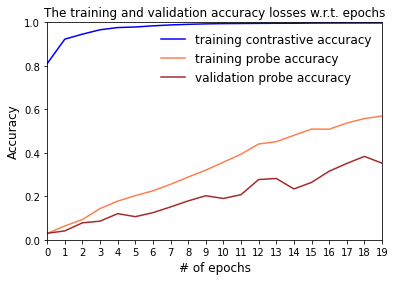

In [90]:
plot_contrastive_train_accuracy(b"results/contrastive_simple_history.pickle")

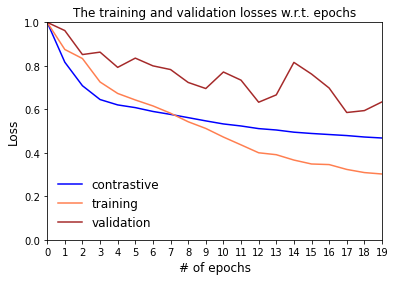

In [91]:
plot_contrastive_train_loss(b"results/contrastive_simple_history.pickle")

# Contrastive learning with VGG16 without fine-tuning

In [92]:
contrastive_encoder_vgg16 = build_vgg16_encoder(image_shape)
contrastive_encoder_vgg16.trainable = False


contrastive_imgaug_vgg16 = CustomisedTrainImageAugmenter(**imgaug_params)

contrastive_model_vgg16 = CustomisedContrastiveModel(   
                                temperature = temperature,
                                encoder = contrastive_encoder_vgg16,
                                train_encoder = False,
                                projhead_hidden_dims = (512, 512, ),
                                projhead_output_dim = 512,
                                image_augmenter = contrastive_imgaug_vgg16,
                                n_classes = n_classes
                            )

contrastive_model_vgg16.compile(
            contrastive_optimizer = keras.optimizers.Adam(learning_rate = 0.001),
            probe_optimizer = keras.optimizers.Adam(),
        )

projhead_input_shape =  512
projhead_hidden_dims =  (512, 512)
projhead_output_dim =  512
Model: "vgg16_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_____________________________

In [93]:
#contrastive_model_vgg16.save("models/contrastive_model_vgg16.saved_model")

In [ ]:
contrastive_vgg16_history = contrastive_model_vgg16.fit(
    train_dataset, 
    epochs=n_epochs, 
    validation_data=test_dataset,
    verbose = 1
)

Epoch 1/20
241/241 [==============================] - 1031s 4s/step - c_loss: 1.7656 - c_acc: 0.8863 - p_loss: 3.3677 - p_acc: 0.4009 - val_p_loss: 2.2782 - val_p_acc: 0.4777
Epoch 2/20
241/241 [==============================] - 1072s 4s/step - c_loss: 1.5576 - c_acc: 0.9179 - p_loss: 1.5770 - p_acc: 0.6369 - val_p_loss: 1.7429 - val_p_acc: 0.4932
Epoch 3/20
241/241 [==============================] - 1075s 4s/step - c_loss: 1.4745 - c_acc: 0.9208 - p_loss: 1.0877 - p_acc: 0.6879 - val_p_loss: 1.5968 - val_p_acc: 0.5357
Epoch 4/20
241/241 [==============================] - 1116s 5s/step - c_loss: 1.4189 - c_acc: 0.9220 - p_loss: 0.9369 - p_acc: 0.7082 - val_p_loss: 1.4864 - val_p_acc: 0.5645
Epoch 5/20
241/241 [==============================] - 1267s 5s/step - c_loss: 1.3875 - c_acc: 0.9216 - p_loss: 0.8554 - p_acc: 0.7274 - val_p_loss: 1.6045 - val_p_acc: 0.5638
Epoch 6/20
206/241 [========================>.....] - ETA: 2:52 - c_loss: 1.3624 - c_acc: 0.9246 - p_loss: 0.8150 - p_acc: 0.

## Saving models and results

In [ ]:
#a tensorflow bug, must call the model first then 
_ = contrastive_model_vgg16(next(iter(train_dataset))[0])

contrastive_encoder_vgg16.save("models/contrastive_encoder_vgg16.saved_model")
contrastive_model_vgg16.save("models/contrastive_model_vgg16.saved_model")

In [ ]:
test_encoder = keras.models.load_model("models/contrastive_encoder_vgg16.saved_model")
test_model = keras.models.load_model("models/contrastive_model_vgg16.saved_model")

del test_encoder
del test_model

In [ ]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(contrastive_vgg16_history.history, 
            open("results/contrastive_vgg16_history.pickle", "wb" ))

In [ ]:
history = pickle.load(open(b"results/contrastive_simple_history.pickle", "rb"))

val_p_acc = max(history["val_p_acc"]) * 100

p_acc = max(history["p_acc"]) * 100
c_acc = max(history["c_acc"]) * 100


print(f"Maximal validation linear prediction accuracy: {val_p_acc:.2f}%")
print(f"Maximal train linear prediction accuracy: {p_acc:.2f}%")
print(f"Maximal train contrastive accuracy: {c_acc:.2f}%")

## Plotting

In [ ]:
plot_contrastive_train_accuracy(b"results/contrastive_vgg16_history.pickle")

In [ ]:
plot_contrastive_train_loss(b"results/contrastive_vgg16_history.pickle")

# Contrastive learning with VGG16 with fine-tuning

# Visualising by projecting using UMAP

# Conclusions